Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)
<br>
[Li-Yi Wei](http://liyiwei.org/), 2016

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 4 - Building Good Training Sets – Data Pre-Processing

Machine learns from data (training set)
* garbage in, garbage out

Data is very important
* quality, form, etc.

This part is about how to pre-process data for better machine learning
* the first stage of the pipeline

<img src="./images/01_09.png" width=90%>

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,sklearn

last updated: 2016-10-04 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
sklearn 0.18


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Dealing with missing data](#Dealing-with-missing-data)
  - [Eliminating samples or features with missing values](#Eliminating-samples-or-features-with-missing-values)
  - [Imputing missing values](#Imputing-missing-values)
  - [Understanding the scikit-learn estimator API](#Understanding-the-scikit-learn-estimator-API)
- [Handling categorical data](#Handling-categorical-data)
  - [Mapping ordinal features](#Mapping-ordinal-features)
  - [Encoding class labels](#Encoding-class-labels)
  - [Performing one-hot encoding on nominal features](#Performing-one-hot-encoding-on-nominal-features)
- [Partitioning a dataset in training and test sets](#Partitioning-a-dataset-in-training-and-test-sets)
- [Bringing features onto the same scale](#Bringing-features-onto-the-same-scale)
- [Selecting meaningful features](#Selecting-meaningful-features)
  - [Sparse solutions with L1 regularization](#Sparse-solutions-with-L1-regularization)
  - [Sequential feature selection algorithms](#Sequential-feature-selection-algorithms)
- [Assessing feature importance with random forests](#Assessing-feature-importance-with-random-forests)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

%matplotlib inline
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version


# Dealing with missing data

The training data might be incomplete due to various reasons
* data collection error
* measurements not applicable
* etc.

Most machine learning algorithms/implementations cannot robustly deal with missing data

Thus we need to deal with missing data before training models

We use pandas (Python data analysis) library for dealing with missing data in the examples below

In [3]:
import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# If you are using Python 2.7, you need
# to convert the string to unicode:
# csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


The columns (A, B, C, D) are features.

The rows (0, 1, 2) are samples.

Missing values become NaN (not a number).

In [4]:
df.isnull()

,A,B,C,D
0,False,False,False,False
1,False,False,True,False
2,False,False,False,True


In [5]:
df.isnull().sum(axis=0)

A    0
B    0
C    1
D    1
dtype: int64

## Eliminating samples or features with missing values

One simple strategy is to simply eliminate samples (table rows) or features (table columns) with missing values, based on various criteria.

In [6]:
# the default is to drop samples/rows
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# but we can also elect to drop features/columns
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [8]:
# only drop rows where all columns are NaN
df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [9]:
# drop rows that have not at least 4 non-NaN values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [10]:
# only drop rows where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


Dropping data might not be desirable, as the resulting data set might become too small.

## Imputing missing values

Interpolating missing values from existing ones can preserve the original data better.

Impute: the process of replacing missing data with substituted values
<a href="https://en.wikipedia.org/wiki/Imputation_(statistics)">in statistics</a>

In [11]:
from sklearn.preprocessing import Imputer

# options from the imputer library includes mean, median, most_frequent

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

For example, 7.5 is the average of 3 and 12.
6 is the average of 4 and 8.


In [12]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

We can do better than this, by selecting only the most similar rows for interpolation, instead of all rows. This is how recommendation system could work, e.g. predict your potential rating of a movie or book you have not seen based on item ratings from you and other users.

<i>Programming Collective Intelligence: Building Smart Web 2.0 Applications, by Toby Segaran</i>
* very good reference book: recommendation system, search engine, etc.
* I didn't choose it as one of the text/reference books as the code/data is a bit out of date
<a href="https://www.amazon.com/Programming-Collective-Intelligence-Building-Applications/dp/0596529325/ref=sr_1_1?s=books&ie=UTF8&qid=1475564389&sr=1-1&keywords=collective+intelligence">
<img src="https://images-na.ssl-images-amazon.com/images/I/51LolW3DugL._SX379_BO1,204,203,200_.jpg" width=25% align=right>
</a>

## Understanding the scikit-learn estimator API

Transformer class for data transformation
* imputer

Key methods
* fit() for fitting from (training) ata
* transform() for transforming future data based on the fitted data

Good API designs are consistent. For example, the fit() method has similar meanings for different classes, such as transformer and estimator. 

### Transformer
<img src='./images/04_04.png' width=80%>

### Estimator
<img src='./images/04_05.png' width=80%> 

# Handling different types of data

There are different types of feature data: numerical and categorical.
Numerical features are numbers and often "continuous" like real numbers.
Categorical features are "discrete", and can be either nominal or ordinal.
* Ordinal values are discrete but carry some numerical meanings such as ordering and thus can be sorted. 
* Nominal values have no numerical meanings.

In the example below:
* color is nominal (no numerical meaning)
* size is ordinal (can be sorted in some way)
* price is numerical

A given dataset can contain features of different types. It is important to handle them carefully. For example, do not treat nominal values as numbers without proper mapping.


In [13]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


## Data conversion

For some estimators such as decision trees that handle one feature at a time, it is OK to keep the features as they are.

However for other estimators that need to handle multiple features together, we need to convert them into compatible forms before proceeding:
1. convert categorical values into numerical values
2. scale/normalize numerical values

## Mapping ordinal features

Ordinal features can be converted into numbers, but the conversion often depends on semantics and thus needs to be specified manually (by a human) instead of automatically (by a machine).

In the example below, we can map sizes into numbers. Intuitively, larger sizes should map to larger values. Exactly which values to map to is often a judgment call.

Below, we use Python dictionary to define a mapping.

In [14]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [15]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## Encoding class labels

Class labels often need to be represented as integers for machine learning libraries
* not ordinal, so any integer mapping will do
* but a good idea and convention is to use consecutive small values like 0, 1, ...

In [16]:
import numpy as np

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [17]:
# forward map
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [18]:
# inverse map
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


We can use LabelEncoder in scikit learn to convert class labels automatically.

In [19]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0], dtype=int64)

In [20]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

## Performing one-hot encoding on nominal features

However, unlike class labels, we cannot just convert nominal features (such as colors) directly into integers.

A common mistake is to map nominal features into numerical values, e.g. for colors
* blue $\rightarrow$ 0
* green $\rightarrow$ 1
* red $\rightarrow$ 2

In [21]:
X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

For categorical features, it is important to keep the mapped values "equal distance"
* unless you have good reasons otherwise

For example, for colors red, green, blue, we want to convert them to values so that each color has equal distance from one another.

This cannot be done in 1D but doable in 2D (how? think about it).

One hot encoding is a straightforward way to make this just work, by mapping n-value nominal feature into n-dimensional binary vector. 
* blue  $\rightarrow$ (1, 0, 0)
* green $\rightarrow$ (0, 1, 0)
* red   $\rightarrow$ (0, 0, 1)

In [22]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [23]:
# automatic conversion via the get_dummies method in pd
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0.0,1.0,0.0
1,13.5,2,0.0,0.0,1.0
2,15.3,3,1.0,0.0,0.0


In [24]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


# Partitioning a dataset in training and test sets

Training set to train the models

Test set to evaluate the trained models

Separate the two to avoid over-fitting
* well trained models should generalize to unseen, test data

Validation set for tuning hyper-parameters
* parameters are trained by algorithms
* hyper-parameters are selected by humans
* will talk about this later

## Wine dataset

A dataset to classify wines based on 13 features and 178 samples.

In [25]:
wine_data_remote = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_data_local = '../datasets/wine/wine.data'

df_wine = pd.read_csv(wine_data_local,
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<hr>

### Note:


If the link to the Wine dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/wine/wine.data](./../datasets/wine.data).

Or you could fetch it via


In [26]:
df_wine = pd.read_csv('https://raw.githubusercontent.com/1iyiwei/pyml/master/code/datasets/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## How to allocate training and test proportions?

As much training data as possible for accurate model

As much test data as possible for evaluation

Usual rules is 60:40, 70:30, 80:20

Larger datasets can have more portions for training
* e.g. 90:10

Other partitions possible
* talk about later in model evaluation and parameter tuning

In [27]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)
    
print(X.shape)

import numpy as np
print(np.unique(y))

(178, 13)
[1 2 3]


# Bringing features onto the same scale

Most machine learning algorithms behave better when features are on similar scales.

Exceptions
* decision trees
* random forests

## Example

Two features, in scale [0 1] and [0 100000]

Think about what happens when we apply 
* perceptron
* KNN

## Two common approaches 

### Normalization
min-max scaler:
$$\frac{x-x_{min}}{x_{max}-x_{min}}$$

### Standardization
standard scaler:
$$\frac{x-x_\mu}{x_\sigma}$$
* $x_\mu$: mean of x values
* $x_\sigma$: standard deviation of x values

Standardization more common as normalization sensitive to outliers

In [28]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [29]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Toy case: standardization versus normalization

In [30]:
ex = pd.DataFrame([0, 1, 2, 3, 4, 5])

# standardize
ex[1] = (ex[0] - ex[0].mean()) / ex[0].std(ddof=0)

# Please note that pandas uses ddof=1 (sample standard deviation) 
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation)

# normalize
ex[2] = (ex[0] - ex[0].min()) / (ex[0].max() - ex[0].min())
ex.columns = ['input', 'standardized', 'normalized']
ex

,input,standardized,normalized
0,0,-1.46385,0.0
1,1,-0.87831,0.2
2,2,-0.29277,0.4
3,3,0.29277,0.6
4,4,0.87831,0.8
5,5,1.46385,1.0


# Selecting meaningful features

Overfitting is a common problem for machine learning. 
* model fits training data too closely and fails to generalize to real data
* model too complex for the given training data

<img src="./images/03_06.png" width=80%>

## Ways to address overfitting

* Collect more training data (to make overfitting less likely)
* Reduce the model complexity explicitly, such as the number of parameters
* Reduce the model complexity implicitly via regularization
* Reduce data dimensionality, which forced model reduction

Amount of data should be sufficient relative to model complexity.

## Objective
We can sum up both the loss and regularization terms as the total objective:
$$\Phi(\mathbf{X}, \mathbf{T}, \Theta) = L\left(\mathbf{X}, \mathbf{T}, \mathbf{Y}=f(\mathbf{X}, \Theta)\right) + P(\Theta)$$

During training, the goal is to optimize the parameters $\Theta$ with respect to the given training data $\mathbf{X}$ and $\mathbf{T}$:
$$argmin_\Theta \; \Phi(\mathbf{X}, \mathbf{T}, \Theta)$$
And hope the trained model with generalize well to future data. 

## Loss
Every machine learning task as a goal, which can be formalized as a loss function:
$$L(\mathbf{X}, \mathbf{T}, \mathbf{Y})$$
, where $\mathbf{T}$ is some form of target or auxiliary information, such as:
* labels for supervised classification
* number of clusters for unsupervised clustering
* environment for reinforcement learning

## Regularization
In addition to the objective, we often care about the simplicity of the model, for better efficiency and generalization (avoiding over-fitting).
The complexity of the model can be measured by another penalty function:
$$P(\Theta)$$
Some common penalty functions include number and/or magnitude of parameters.

## Regularization

For weight vector $\mathbf{w}$ of some model (e.g. perceptron or SVM)

$L_2$:
$
\|\mathbf{w}\|_2^2 = \sum_{k} w_k^2
$

$L_1$:
$
\|\mathbf{w}\|_1 = \sum_{k} \left|w_k \right|
$

$L_1$ tends to produce sparser solutions than $L_2$
* more zero weights
* more like feature selection

<img src='./images/04_12.png' width=80%>

<img src='./images/04_13.png' width=80%> 

We are more likely to bump into sharp corners of an object.

Experiment: drop a circle and a square into a flat floor.
What is the probability of hitting any point on the shape?

<img src="./images/sharp_and_round.svg" width=80%>

How about a non-flat floor, e.g. concave or convex with different curvatures?

## Regularization in scikit-learn

Many ML models support regularization with different
* methods (e.g. $L_1$ and $L_2$) 
* strength (the $C$ value inversely proportional to regularization strength)

In [31]:
from sklearn.linear_model import LogisticRegression

# l1 regularization
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)

# compare training and test accuracy to see if there is overfitting
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


In [32]:
# 3 sets of parameters due to one-versus-rest with 3 classes
lr.intercept_

array([-0.38382483, -0.15805666, -0.70047425])

In [33]:
# 13 coefficients for 13 wine features; notice many of them are 0
lr.coef_

array([[ 0.28015921,  0.        ,  0.        , -0.02805353,  0.        ,
         0.        ,  0.7100341 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23627295],
       [-0.64406395, -0.0687009 , -0.05722121,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92653826,
         0.06030904,  0.        , -0.37107049],
       [ 0.        ,  0.06153062,  0.        ,  0.        ,  0.        ,
         0.        , -0.63555782,  0.        ,  0.        ,  0.49787933,
        -0.35833652, -0.57182511,  0.        ]])

In [34]:
from sklearn.linear_model import LogisticRegression

# l2 regularization
lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(X_train_std, y_train)

# compare training and test accuracy to see if there is overfitting
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 1.0


In [35]:
# notice the disappearance of 0 coefficients due to L2
lr.coef_

array([[ 0.58228361,  0.04305595,  0.27096654, -0.53333363,  0.00321707,
         0.29820868,  0.48418851, -0.14789735, -0.00451997,  0.15005795,
         0.08295104,  0.38799131,  0.80127898],
       [-0.71490217, -0.35035394, -0.44630613,  0.32199115, -0.10948893,
        -0.03572165,  0.07174958,  0.04406273,  0.20581481, -0.71624265,
         0.39941835,  0.17538899, -0.72445229],
       [ 0.18373457,  0.32514838,  0.16359432,  0.15802432,  0.09025052,
        -0.20530058, -0.53304855,  0.1117135 , -0.21005439,  0.62841547,
        -0.4911972 , -0.55819761, -0.04081495]])

## Plot regularization

$C$ is inverse to the regularization strength

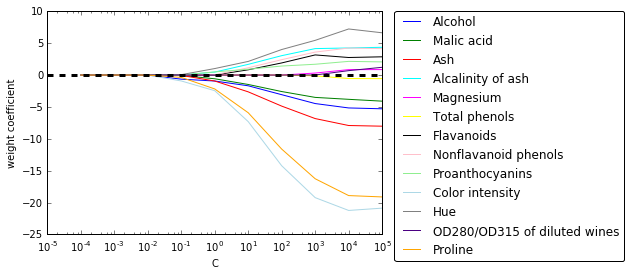

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

# Dimensionality reduction

$L_1$ regularization implicitly selects features via zero out

Feature selection
* explicit - you specify how many features to select, the algorithm picks the most relevant (not important) ones
* forward, backward
* next topic

Note: 2 important features might be highly correlated, and thus it is relevant to select only 1

Feature extraction
* implicit
* can build new, not just select original, features
* e.g. PCA
* next chapter

## Sequential feature selection algorithms

Feature selection is a way to reduce input data dimensionality. You can think of it as reducing the number of columns of the input data table/frame. 

How do we decide which features/columns to keep? Intuitively, we want to keep relevant ones and remove the rest.

We can select these features sequentially, either forward or backward.

### Backward selection

Sequential backward selection (SBS) is a simple heuristic. The basic idea is to start with $n$ features, and consider all possible $n-1$ subfeatures, and remove the one that matters the least for model training.

We then move on to reduce the number of features further ($[n-2, n-3, \cdots]$) until reaching the desired number of features.

In [37]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

Below we try to apply the SBS class above.
We use the KNN classifer, which can suffer from curse of dimensionality.

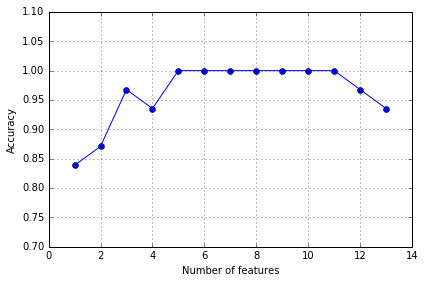

In [38]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [39]:
# list the 5 most important features
k5 = list(sbs.subsets_[8]) # 5+8 = 13
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [40]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


In [41]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


Note the improved test accuracy by fitting lower dimensional training/test data.

### Forward selection

This is essetially the reverse of backward selection; we will leave this as an exercise.

# Assessing Feature Importances with Random Forests

Recall
* a decision tree is built by splitting nodes
* each node split is to maximize information gain
* random forest is a collection of decision trees with randomly selected features

Information gain (or impurity loss) at each node can measure the importantce of the feature being split

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


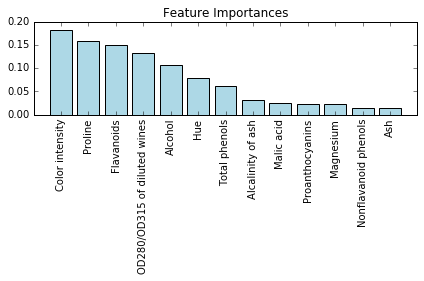

In [42]:
# feature_importances_ from random forest classifier records this info
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

In [43]:
threshold = 0.15
if False: #Version(sklearn_version) < '0.18':
    X_selected = forest.transform(X_train, threshold=threshold)
else:
    from sklearn.feature_selection import SelectFromModel
    sfm = SelectFromModel(forest, threshold=threshold, prefit=True)
    X_selected = sfm.transform(X_train)

X_selected.shape

(124, 3)

Now, let's print the 3 features that met the threshold criterion for feature selection that we set earlier (note that this code snippet does not appear in the actual book but was added to this notebook later for illustrative purposes):

In [44]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948


# Summary

Data is important for machine learning: garbage in, garbage out.
So pre-process data is important.
This chapter covers various topics for data processing, such as handling missing data, treating different types of data (numerical, categorical), and how to avoid over-fitting which can improve both accuracy and speed.

# Reading
* PML Chapter 4
* IML Chapter 6.2